# 2023 Mātai Intern fMRI workshop
By Josh McGeown, PhD

<img src="./supp/rubiks.jpg" 
     align="center" 
     width="300"
     height="300" />

### What is a voxel?

### What is a volume?

### What is the BOLD response?

__B__lood <br>
__O__xygen <br>
__L__evel <br>
__D__ependent <br>

<img src="./supp/bold.png" 
     align="center" 
     width="600"
     height="600" />
     
Image credit: Andy's Brain Book https://andysbrainbook.readthedocs.io/en/latest/_images/BOLD_Response.png

## What is fMRI?

See this simple explanation: https://www.youtube.com/watch?v=4UOeBM5BwdY

## Task-based fMRI

<img src="./supp/task_design.png" 
     align="center" 
     width="400"
     height="400" />

***

<img src="./supp/design_hrf.png" 
     align="center" 
     width="600"
     height="600" />
     
Image credit: FSL Introduction to Task FMRI Experiments and Analysis (https://www.youtube.com/watch?v=y7wtbMl3y4E)

## Resting-state fMRI and functional connectivity

Neurosynth example: https://www.neurosynth.org/analyses/terms/default%20mode/

<img src="./supp/fMRI.png" 
     align="center" 
     width="800"
     height="800" />

### A note on preprocessing

<img src="./supp/fmriprep.png" 
     align="center" 
     width="800"
     height="800" />
     
Image credit: fMRIPREP https://fmriprep.org/en/stable/_static/OHBM2018-poster.png
     
***

***
# Time to work with some data

## Install the tools we need to process our data <br>
__Note: We only need to do this the first time we run the code__

In [1]:
pip install nilearn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install mne

Note: you may need to restart the kernel to use updated packages.


### Load the tools (aka libraries) we will need

In [3]:
import os
import glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import nibabel as nib
from nilearn import datasets
from nilearn import input_data
from nilearn import plotting
from nilearn import image
from nilearn.input_data import NiftiMapsMasker
from nilearn.input_data import NiftiSpheresMasker

from scipy import stats
from mne.stats import fdr_correction

C:\Users\jpmcg\anaconda3\lib\site-packages\nilearn\input_data\__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


### Figure out where we are on our computer

In [4]:
workingdir = os.getcwd()
print(workingdir)
datadir = /nesi/nobackup/uoa03264/Workshop/fmri
print(datadir)

C:\Users\jpmcg\OneDrive - Mātai Medical Research Institute\Desktop\intern_fmriprep_workshop


### Define scan id

In [5]:
cohort = 'rugby'
subject = 1
session = 'b'

### Load resting-state fMRI data

In [6]:
func_file = func_file = glob.glob(datadir + 
                                  '/sub-{cohort}{subject}_ses-{session}_task-rest_run-001_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz'.format(
                                      cohort = cohort, 
                                      subject = subject, 
                                      session = session))[0]

# print basic information on the dataset
print('First subject functional nifti image (4D) is at: %s' %
      func_file)  # 4D data

First subject functional nifti image (4D) is at: C:\Users\jpmcg\OneDrive - Mātai Medical Research Institute\Desktop\intern_fmriprep_workshop/bids/derivatives/sub-rugby2/ses-002/func/sub-rugby2_ses-002_task-rest_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz


### Load raw echo-planar imaging (EPI) data

In [8]:
epi_img = nib.load(func_file)
epi_img_data = epi_img.get_fdata()
print(epi_img_data.shape)

(97, 115, 97, 200)


### This means each "rubiks cube" is 97 voxels _wide_, 97 voxels _tall_, and 115 voxels _deep_ and we have __200__ images

### Plot mean of raw EPI image

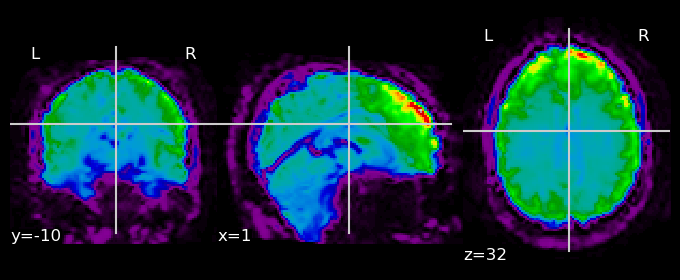

In [10]:
mean_epi = image.mean_img(epi_img)
plotting.plot_epi(mean_epi)

### Time to apply a mask

<img src="./supp/masking.jpg" 
     align="center" 
     width="500"
     height="500" />
     
Image credit to Elizabeth DuPre from _An introduction to nilearn_ https://emdupre.github.io/nha2020-nilearn/01-data-structures.html

### Load image mask

(97, 115, 97)

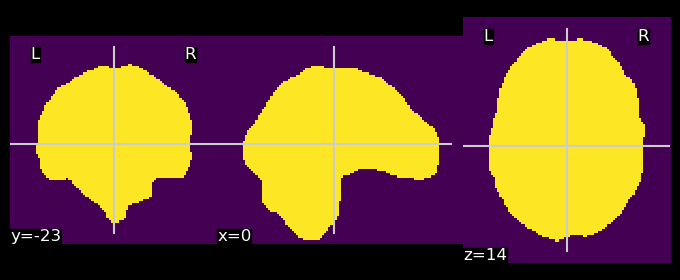

In [11]:
mask_file = glob.glob(datadir + 
                      '/sub-{cohort}{subject}_ses-{session}_task-rest_run-001_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz'.format(
                          cohort = cohort, 
                          subject = subject, 
                          session = session))[0]
mask = nib.load(mask_file)
plotting.plot_img(mask, black_bg = True)
mask.shape

### Plot mask over averaged raw EPI image

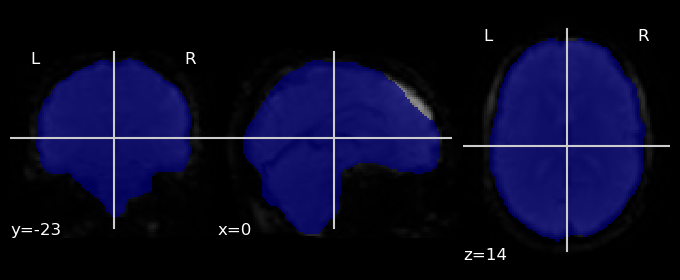

In [12]:
plotting.plot_roi(mask, mean_epi)

## Placing a seed to inspect BOLD signal within a single voxel

### Load parameters we will need to clean our data

In [13]:
rep_time = 1.5 # Repetition time of scan
hp = 0.01 # High pass filter
lp = 0.1 # Low pass filter
fwhm = 6 #Full width half maximum smoothing filter

C:\Users\jpmcg\anaconda3\lib\site-packages\nilearn\plotting\img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


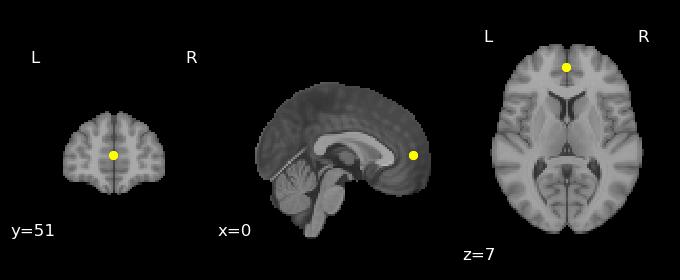

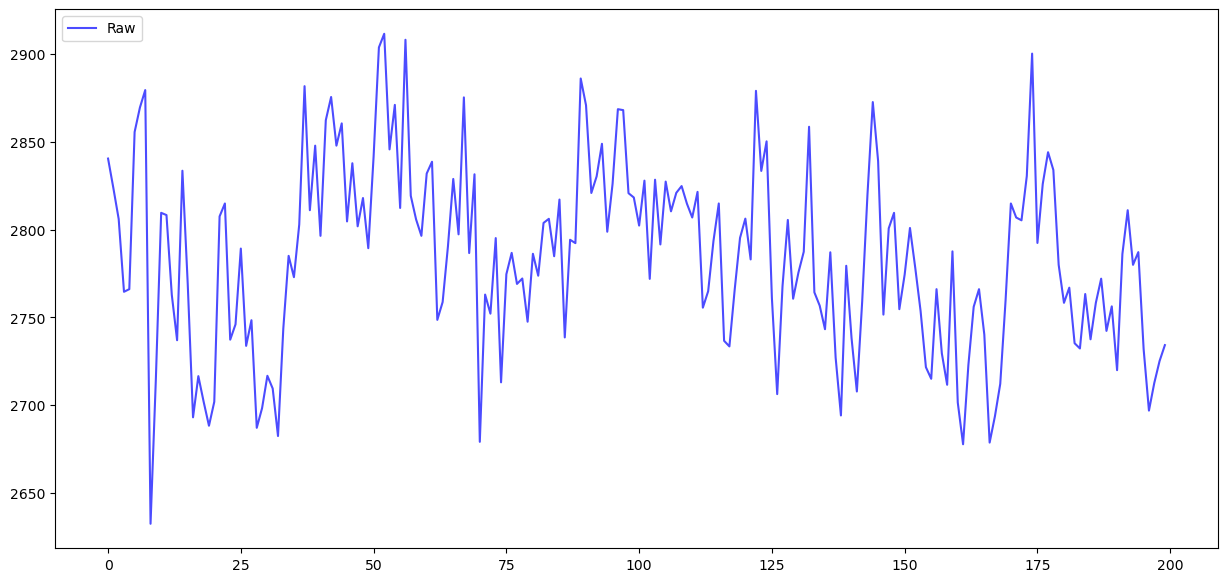

In [14]:
coords = [(-0.15, 51.42, 7.58)]
x, y, z = [0, 51, 8]

display = plotting.plot_anat(cut_coords=coords[0], black_bg = True, draw_cross = False)
display.add_markers(marker_coords=coords, marker_color='yellow',
                    marker_size=30)
display.add_markers(marker_coords=coords, marker_color='yellow',
                    marker_size=30)

seed_mask = input_data.NiftiSpheresMasker(coords,
                                          radius=0, 
                                          detrend=False, 
                                          standardize=False, 
                                          t_r=rep_time,
                                          memory='nilearn_cache',
                                          memory_level=1,
                                          verbose=0,
                                          mask_img = mask)

seed_ts = seed_mask.fit_transform(func_file)

fig = plt.figure(figsize = (15,7))
plt.plot(seed_ts, 'b', alpha = 0.7)
plt.legend(['Raw'], loc = 'upper left')

## Signal-to-Noise

Things that can introduce noise in MRI: <br>
- Items interfering with magnetic field i.e. braces, metal implants
- Electromagnetic properties of other equipment nearby
- Gross motion
- Physiological motion (breathing/heart rate)
- Properties of tissues we aren't trying to study

<img src="./supp/snr.png" 
     align="left" 
     width="8000"
     height="8000" />

### Load confounding (aka nuisance) data that contributes noise to our signal

In [15]:
from IPython.display import display

confound_file = glob.glob(datadir + 
                          '/sub-{cohort}{subject}_ses-{session}_task-rest_run-001_desc-confounds_timeseries.tsv'.format(
                              cohort = cohort, 
                              subject = subject, 
                              session = session))[0]

confounds = pd.read_csv(confound_file, sep = '\t')
confounds = confounds.iloc[:, :-1]
display(confounds.head())

confounds_matrix = confounds.values

,csf,white_matter,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
0,2473.923200,1934.774272,0.032998,-0.086179,-0.224724,0.000512,-0.000394,0.000655
1,2450.632729,1930.318371,0.033705,-0.071502,-0.166813,0.001507,-0.000015,0.000700
2,2439.057409,1929.350182,0.004929,-0.083642,-0.099121,-0.000081,-0.000594,0.000106
3,2429.870135,1930.209205,0.002723,-0.068262,-0.140071,-0.000491,-0.000724,0.000249
4,2424.555228,1928.838069,0.024317,-0.067827,-0.143028,0.000978,-0.000488,0.000735


<img src="./supp/6dof.png" 
     align="center" 
     width="800"
     height="400" />

## Let's look at how to maximize the Signal-to-Noise Ratio
### First we detrend, standardize, regress confounds out of the data
We do this because we are more interested in __patterns__ of activity than __absolute__ values which can vary voxel to voxel and across session/people

In [16]:
seed_mask = input_data.NiftiSpheresMasker(coords,
                                          radius=0, 
                                          detrend=True, # Changed this setting to True
                                          standardize=True, # Changed this setting to True
                                          t_r=rep_time,
                                          memory='nilearn_cache',
                                          memory_level=1,
                                          verbose=0)


seed_ts_ds_c = seed_mask.fit_transform(func_file,
                                    confounds = confounds_matrix)

Text(0.5, 0, 'Samples (time)')

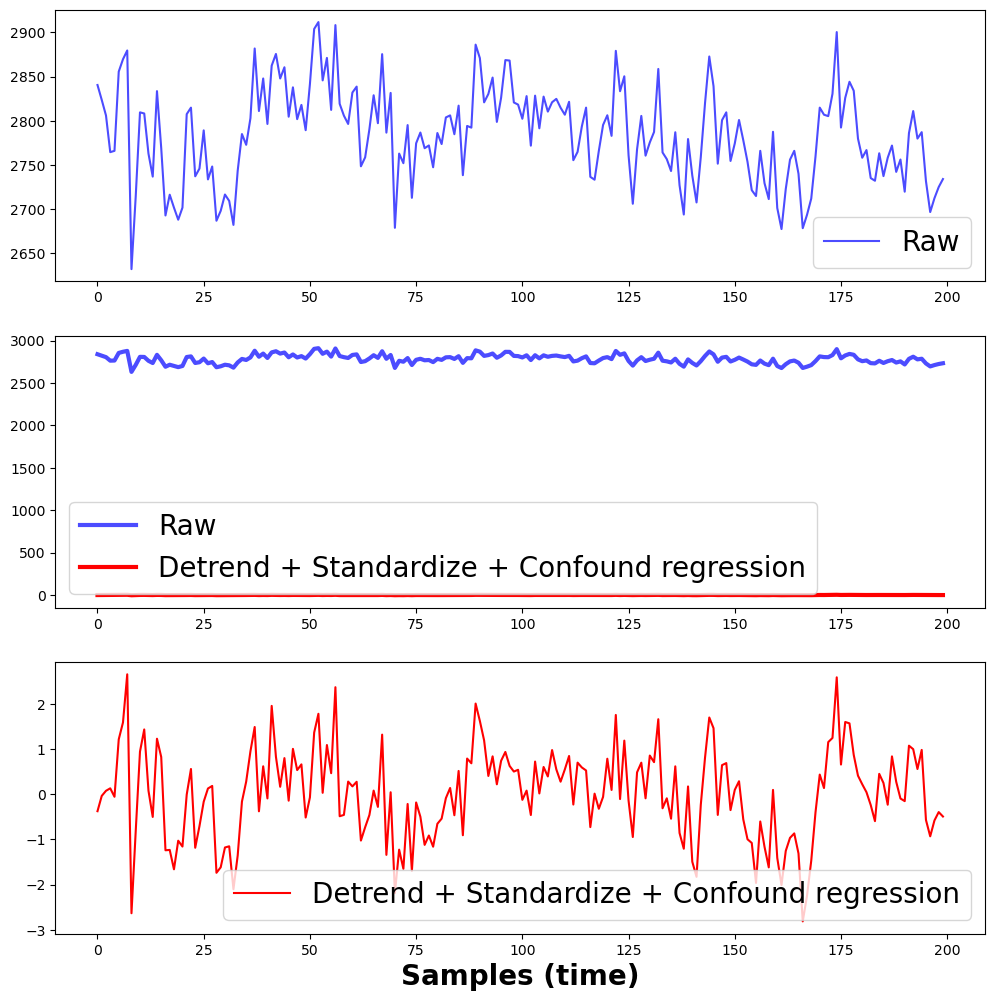

In [17]:
fig, ax = plt.subplots(nrows = 3, figsize=(12,12))

ax[0].plot(seed_ts, 'b', alpha = 0.7)
ax[0].legend(['Raw'], fontsize = 20)

ax[1].plot(seed_ts, 'b', alpha = 0.7, linewidth = 3)
ax[1].plot(seed_ts_ds_c, 'r', linewidth = 3)
ax[1].legend(['Raw', 'Detrend + Standardize + Confound regression'], fontsize = 20)

ax[2].plot(seed_ts_ds_c, 'r')
ax[2].legend(['Detrend + Standardize + Confound regression'], fontsize = 20)

ax[2].set_xlabel('Samples (time)', fontweight = 'bold', fontsize = 20)

### This looks better but we still need to filter our data

### Filter signal using a bandpass filter

In [18]:
seed_mask = input_data.NiftiSpheresMasker(coords,
                                          radius=0, 
                                          detrend=True, 
                                          standardize=True, 
                                          high_pass=hp, # Define the high frequency limit of bandpass filter
                                          low_pass=lp, # Define the low frequency limit of bandpass filter
                                          t_r=rep_time,
                                          memory='nilearn_cache',
                                          memory_level=1,
                                          verbose=0)

seed_ts_ds_c_f = seed_mask.fit_transform(func_file, confounds = confounds_matrix)

Text(0.5, 0, 'Samples (time)')

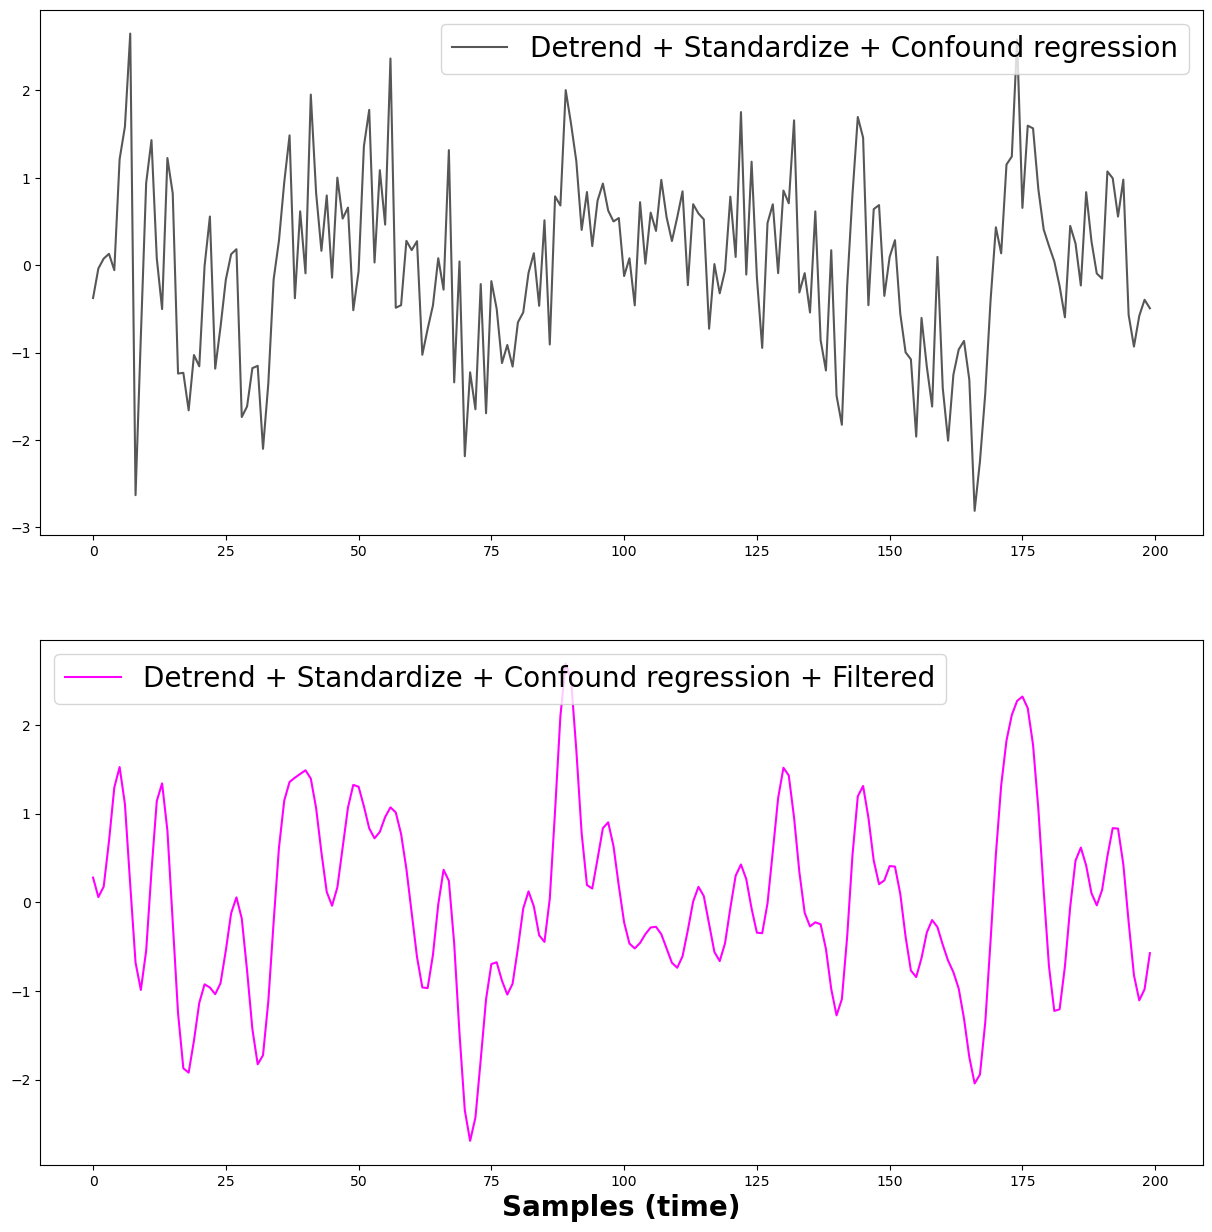

In [19]:
fig, ax = plt.subplots(nrows = 2, figsize=(15,15))

ax[0].plot(seed_ts_ds_c, 'k', alpha = 0.66)
ax[0].legend(["Detrend + Standardize + Confound regression"], fontsize = 20)
ax[1].plot(seed_ts_ds_c_f, 'magenta')
ax[1].legend(["Detrend + Standardize + Confound regression + Filtered"], fontsize = 20)

ax[1].set_xlabel('Samples (time)', fontweight = 'bold', fontsize = 20)

## Exploring functional connectivity within brain networks
Atlases allow us to easily and efficiently identify different regions of interest within the brain for our analysis

### Load the MSDL atlas

In [20]:
atlas = datasets.fetch_atlas_msdl()
atlas_filename = atlas['maps']

atlas_df = pd.DataFrame.from_dict(atlas)
display(atlas_df.iloc[:, 1:-1].head(10))


Dataset created in C:\Users\jpmcg/nilearn_data\msdl_atlas



 ...done. (2 seconds, 0 min)
Extracting data from C:\Users\jpmcg/nilearn_data\msdl_atlas\01a216f54c9220cf2626a4d2eebe3981\MSDL_rois.zip..... done.


,labels,region_coords,networks
0,L Aud,"[-53.28, -8.88, 32.36]",Aud
1,R Aud,"[53.47, -6.49, 27.52]",Aud
2,Striate,"[1.18, -74.54, 10.79]",Striate
3,L DMN,"[-45.8, -64.78, 31.84]",DMN
4,Med DMN,"[-0.2, -55.21, 29.87]",DMN
5,Front DMN,"[-0.15, 51.42, 7.58]",DMN
6,R DMN,"[51.66, -59.34, 28.88]",DMN
7,Occ post,"[0.41, -91.05, 1.58]",Occ post
8,Motor,"[-1.48, -27.93, 61.5]",Motor
9,R DLPFC,"[40.1, 20.96, 44.72]",R V Att


__These are the 16 networks available within the MSDL atlas:__ <br>
- 'Ant IPS' 
- 'Aud' 
- 'Basal' 
- 'Cereb', 
- 'Cing-Ins'
- 'D Att'
- 'DMN'
- 'Dors PCC' 
- 'L V Att'
- 'Language' 
- 'Motor'
- 'Occ post'
- 'R V Att'
- 'Salience'
- 'Striate'
- 'Temporal' 
- 'Vis Sec' 

In [21]:
#Generate blank dictionary of 16 unique msdl_networks
keys = list(set(atlas['networks']))
msdl_networks = dict.fromkeys(keys)
for key in msdl_networks.keys():
    msdl_networks[key] = []

#Populate dictionary with indexes of anatomical seeds that correspond to functional networks
for i in range(0, len(atlas['networks'])):
    temp = atlas['networks'][i]
    if temp in msdl_networks.keys():
        msdl_networks[temp].append(i)
    else:
        msdl_networks[temp] = None

### Plot map for all networks within MSDL atlas individually

C:\Users\jpmcg\anaconda3\lib\site-packages\numpy\ma\core.py:2829: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


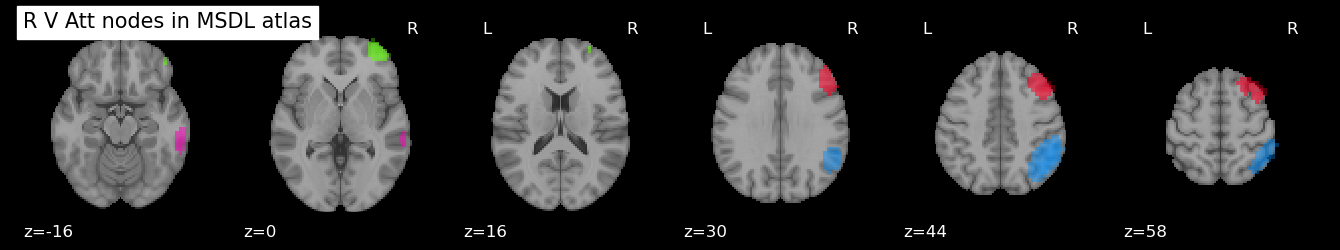

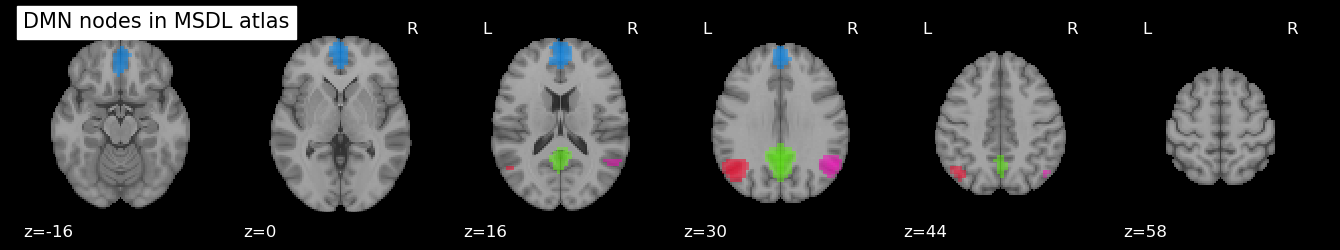

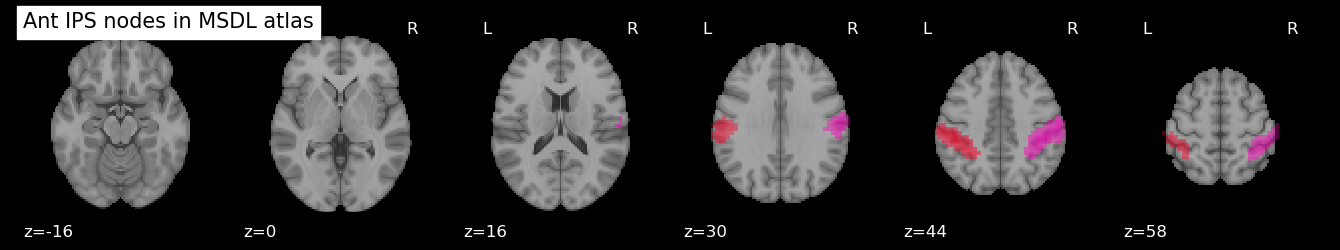

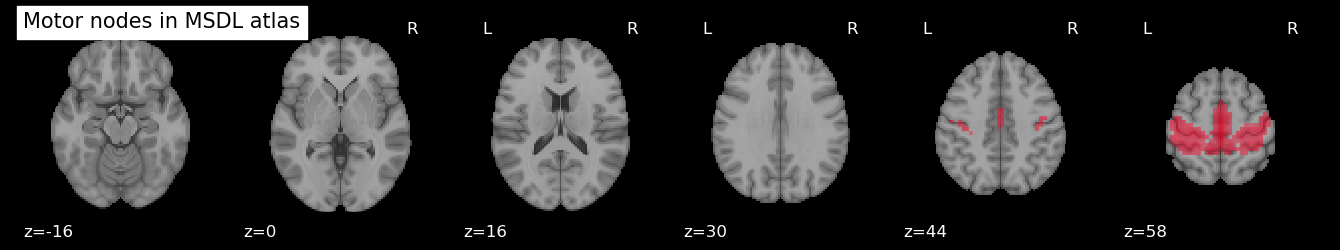

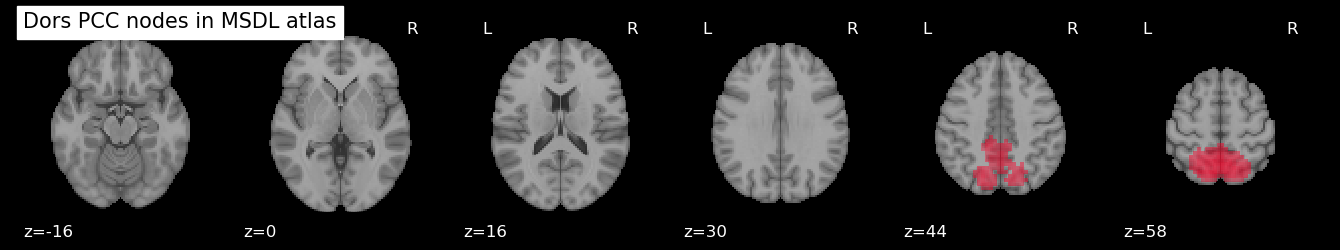

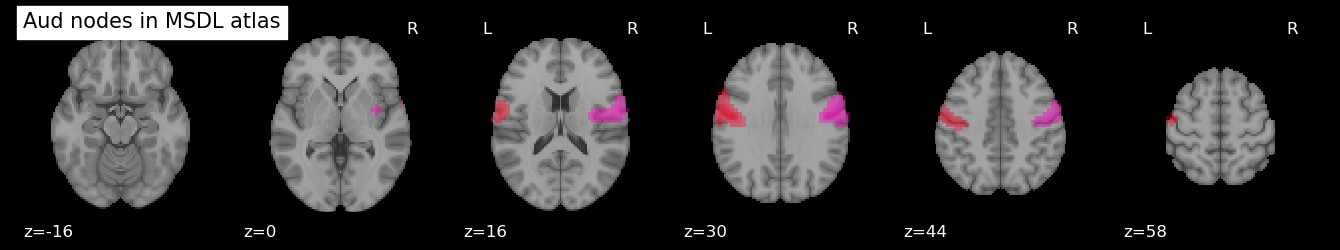

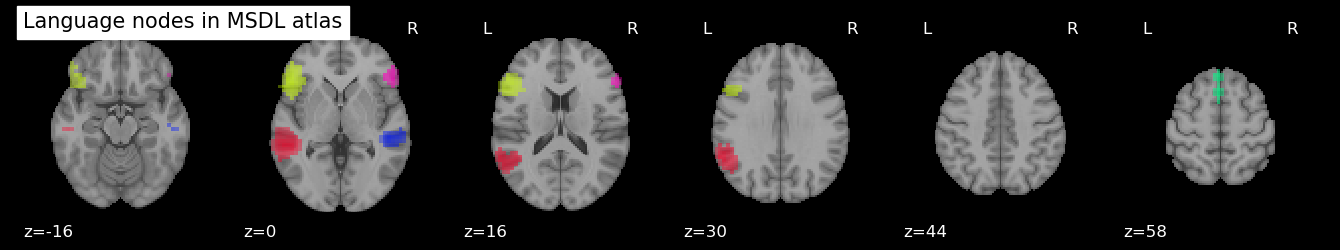

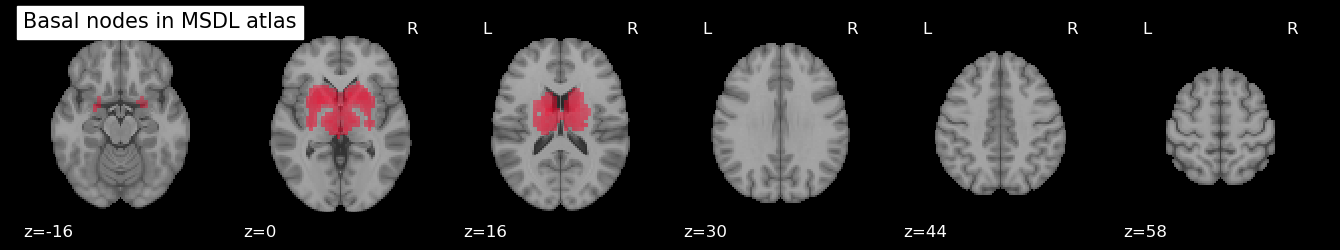

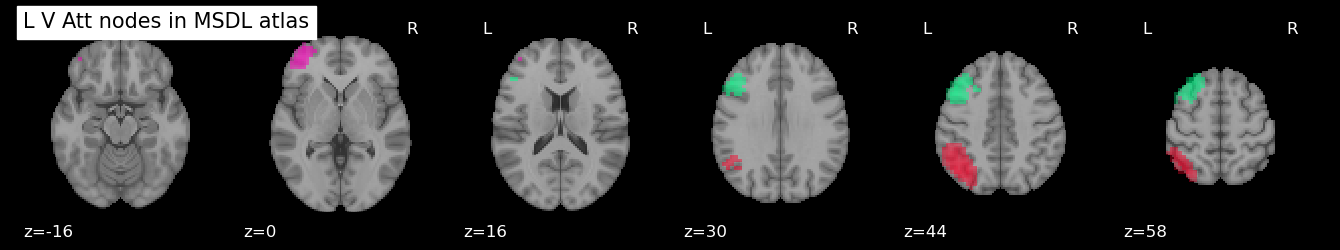

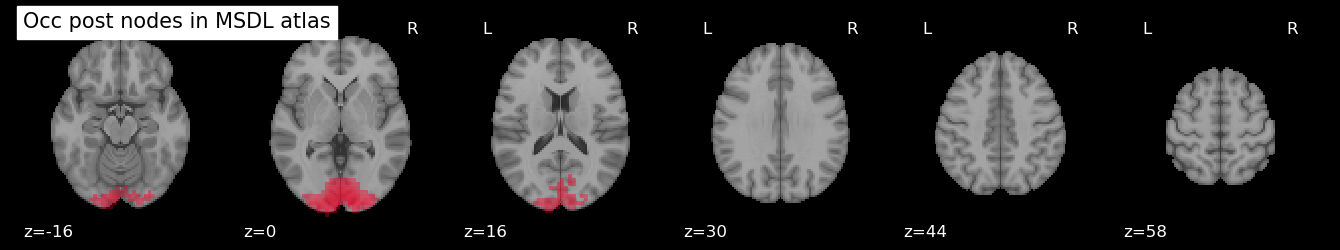

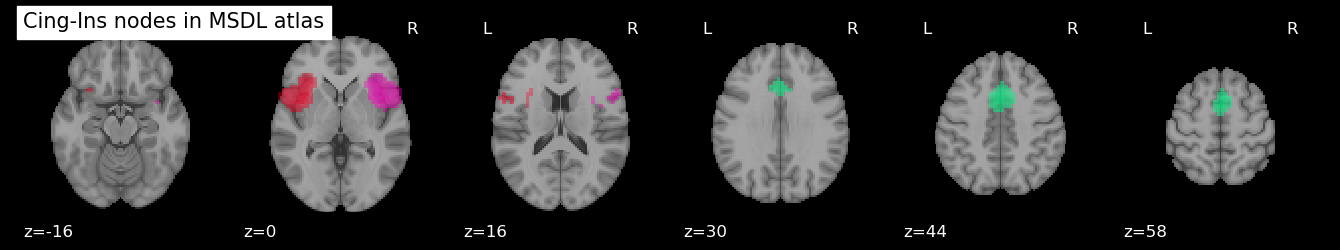

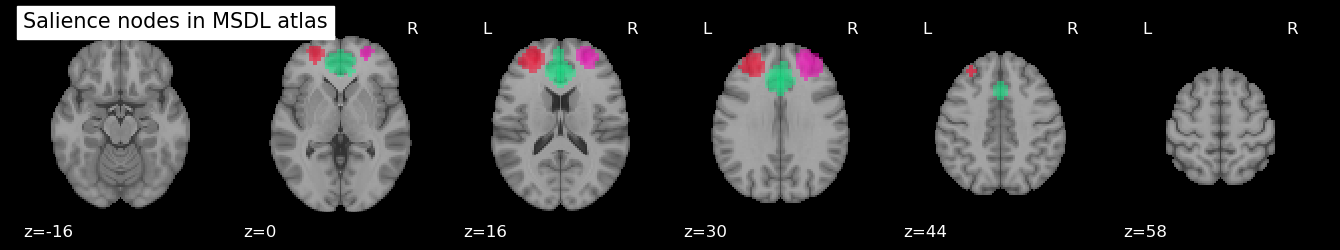

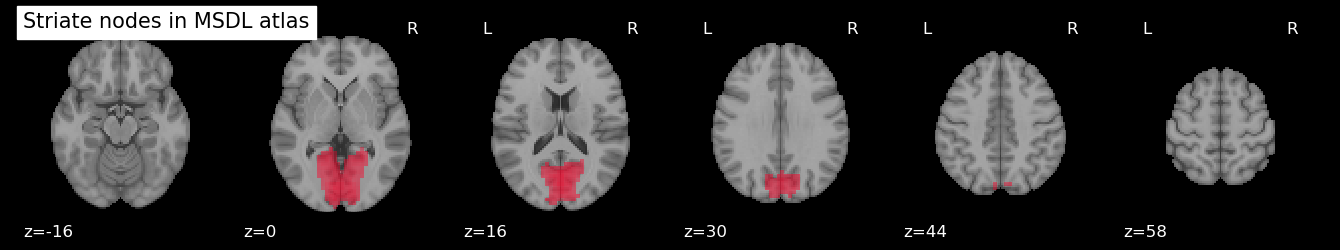

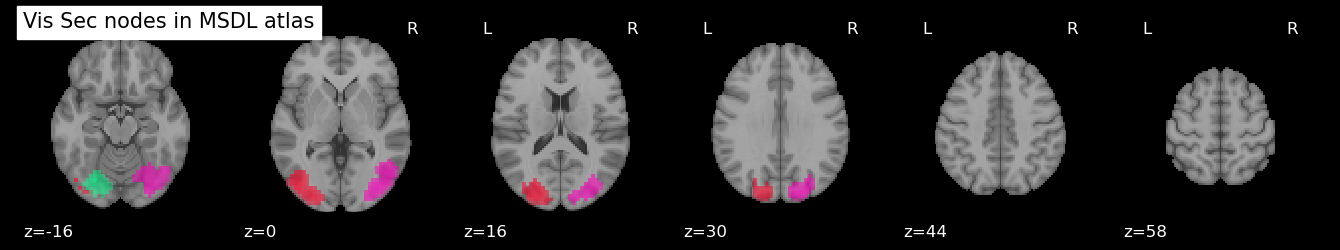

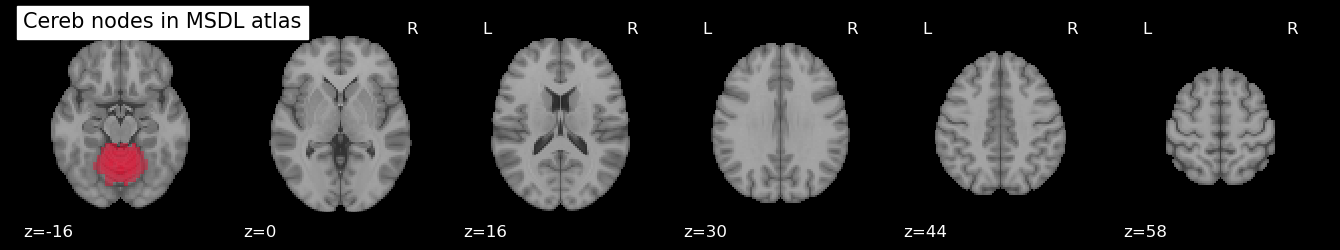

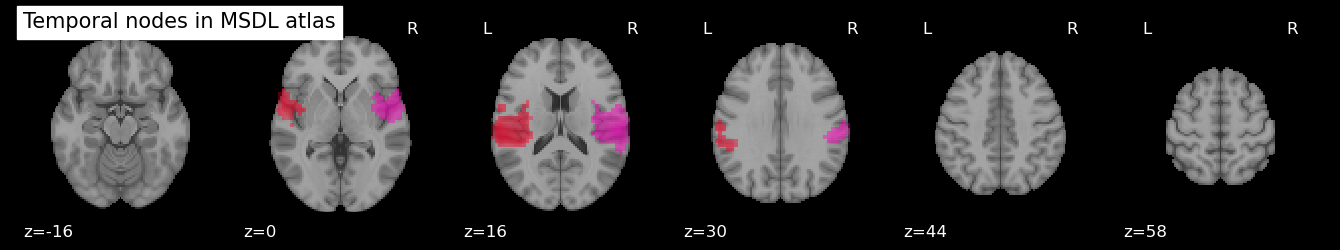

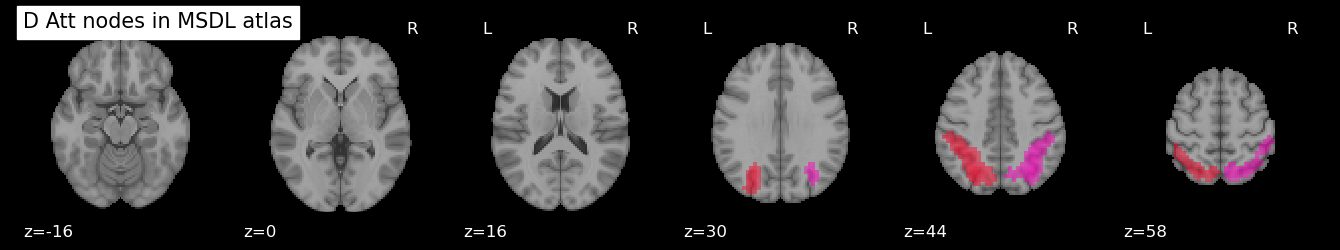

In [22]:
# View probabilistic map for all networks within atlas individually
for i in keys:
    network_nodes = image.index_img(atlas_filename, msdl_networks[i])
    atlas_plot = plotting.plot_prob_atlas(network_nodes, 
                                          cut_coords = 6, 
                                          display_mode='z', 
                                          title='{ntwk} nodes in MSDL atlas'.format(ntwk=i),
                                          black_bg = True)

In [23]:
auditory_L = [(-53.28, -8.88, 32.36)]
auditory_R= [(53.47, -6.49, 27.52)]
motor = [(-1.48, -27.93, 61.5)]

seed_list = [auditory_L, auditory_R, motor]

voxel_ts_array = np.zeros((200,1))

for seed in seed_list:
    seed_mask = input_data.NiftiSpheresMasker(seed,
                                              radius=10, 
                                              detrend=True, 
                                              standardize=True, 
                                              low_pass=lp, 
                                              high_pass=hp,
                                              t_r=rep_time,
                                              memory='nilearn_cache',
                                              memory_level=1,
                                              verbose=0)


    voxel_ts = seed_mask.fit_transform(func_file, confounds=confounds_matrix)
    voxel_ts_array = np.column_stack((voxel_ts_array, voxel_ts))
    
print(voxel_ts_array[:, 1:].shape)

(200, 3)


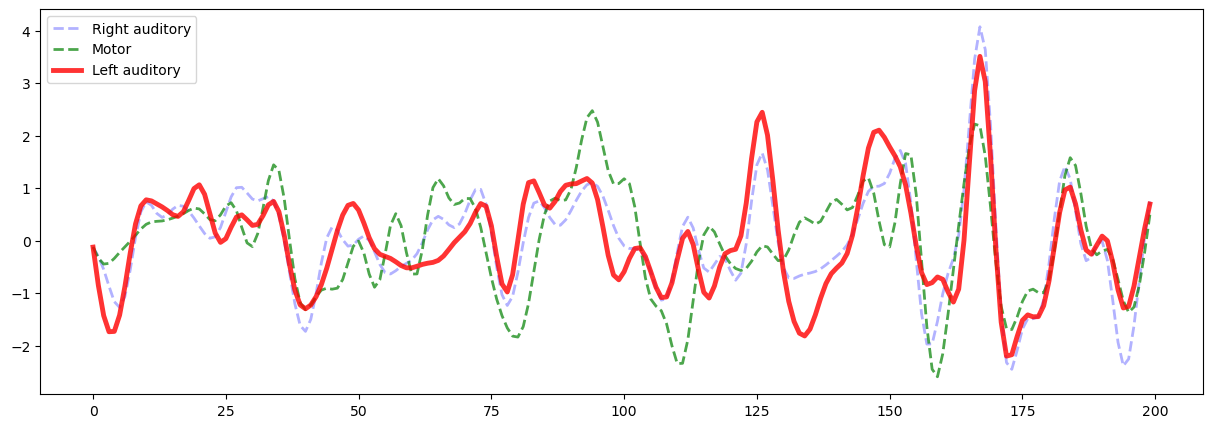

In [24]:
fig = plt.figure(figsize = (15,5))

plt.plot(voxel_ts_array[:, 2], 'b--', alpha = 0.3, linewidth = 2)
plt.plot(voxel_ts_array[:, 3], 'g--', alpha = 0.7, linewidth = 2)
plt.plot(voxel_ts_array[:, 1], 'r', alpha = 0.8, linewidth = 3.5)
plt.legend(['Right auditory', 'Motor', 'Left auditory'], loc = 'upper left')

### Plot our example network of interest - Default Mode Network

(40, 48, 35, 4)


C:\Users\jpmcg\anaconda3\lib\site-packages\numpy\ma\core.py:2829: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


<Figure size 1000x500 with 0 Axes>

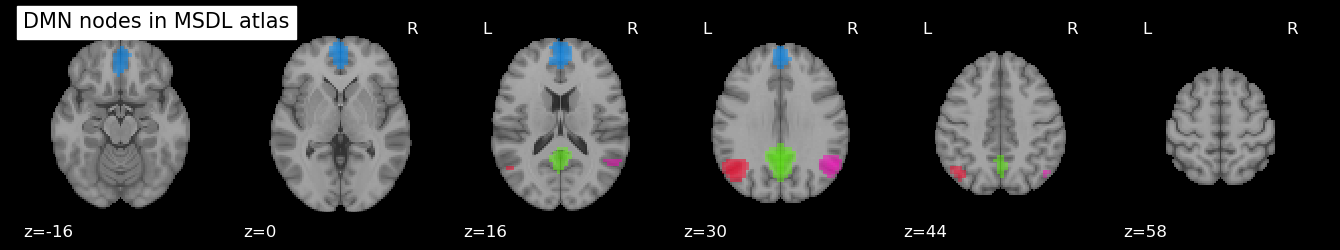

In [25]:
# Define single network and plot probabilistic map from atlas
ntwk = 'DMN' # Functional network of interest

fig = plt.figure(figsize=(10,5)) #Create fig object to plot atlas and subject bold signal together

network_nodes = image.index_img(atlas_filename, msdl_networks[ntwk]) #define nodes
print(network_nodes.shape)
   
atlas_plot = plotting.plot_prob_atlas(network_nodes, cut_coords = 6,
                                      display_mode='z', 
                                      title='{ntwk} nodes in MSDL atlas'.format(ntwk=ntwk),
                                      black_bg = True)

### Generate a mask for the nodes of the DMN

In [26]:
atlas_masker = NiftiMapsMasker(
    maps_img= network_nodes,
    smoothing_fwhm = fwhm,
    standardize=True, 
    detrend = True,
    low_pass= lp, 
    high_pass= hp, 
    t_r=rep_time, 
    memory='nilearn_cache',
    memory_level=1,
    verbose = 0, 
    mask_img = mask)

network_time_series = atlas_masker.fit_transform(func_file, 
                                                 confounds= confounds_matrix) # time series for network of interest

### Mask the whole brain

In [27]:
brain_masker = input_data.NiftiMasker(
    smoothing_fwhm= fwhm,
    detrend=True, 
    standardize=True,
    low_pass= lp, 
    high_pass= hp, 
    t_r=rep_time,
    memory='nilearn_cache', 
    memory_level=1, 
    verbose=0, 
    mask_img=mask)

brain_time_series = brain_masker.fit_transform(func_file,
                                               confounds = confounds_matrix)

### Look at what the masking steps have done

In [28]:
print("Seed time series shape: (%s, %s)" % network_time_series.shape)
print("Brain time series shape: (%s, %s)" % brain_time_series.shape)

Seed time series shape: (200, 4)
Brain time series shape: (200, 240185)


### Calculate correlation between BOLD signal in seeds of interest vs every other voxel in the brain

In [29]:
#Correlate network nodes of interest against brain mask time series
network_to_voxel_correlations = (np.dot(brain_time_series.T, network_time_series) /
                              network_time_series.shape[0])

print("Network-to-voxel correlation shape: (%s, %s)" %
      network_to_voxel_correlations.shape)
print("Network-to-voxel correlation: min = %.3f; max = %.3f" % (
    network_to_voxel_correlations.min(), network_to_voxel_correlations.max()))

Network-to-voxel correlation shape: (240185, 4)
Network-to-voxel correlation: min = -0.841; max = 0.966


### Plot voxels where BOLD signal correlates with the BOLD signal from our seed

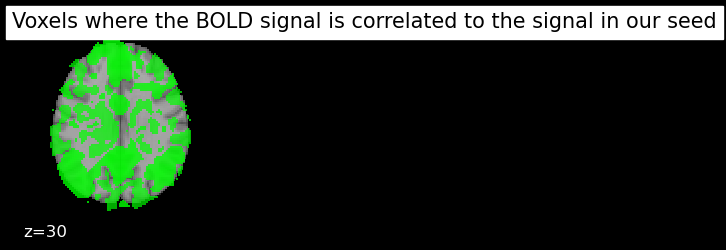

In [30]:
network_to_voxel_correlations_img = brain_masker.inverse_transform(network_to_voxel_correlations.mean(axis=1).T)

display = plotting.plot_stat_map(network_to_voxel_correlations_img,
                                      threshold= 0.1,
                                      cut_coords=[30],                                     
                                      display_mode='z',
                                      vmax = 1,
                                      title="Voxels where the BOLD signal is correlated to the signal in our seed",
                                      cmap = 'green_transparent',
                                      colorbar=False,
                                      black_bg = True)

## Multiple comparisons
- p-value of 0.05 means we are willing to accept a false positive 5% of the time <br>
- But this assumes we are only conducting one test <br>
- If we conduct multiple tests on related data... say 20 tests ... we would expect at least one of the tests to be a fall positive 1/20 = 5% <br>
- In some studies we account for this by shrinking the p-value based on the number of tests i.e. 0.05/20 = 0.0025 <br>
- Now a p-value has to be < 0.0025 to be "significant"

But in imaging we have a problem of big numbers... in the case of the data we are working with we have 240185 correlations against our seed (the total number of voxels we are evaluating)

Based on our typical false positive rate we would expect at least 12000 voxels will show a relationship with our seed that is purely random

To correct for this we would have to divide our p-value by 240185 (the total number of voxels we are evaluting) which would make our new p-value: 0.0000002080

Instead we account for this problem using a technique called the __False Discovery Rate (FDR)__

In [31]:
fdr_alpha = 0.01 # False detection rate p-value threshold

#calculate t statistics from network_to_voxel_correlations
t_vals = (network_to_voxel_correlations * np.sqrt((epi_img.shape[3]-2))) / np.sqrt((1 - network_to_voxel_correlations**2))

#convert t statistics to p values
p_vals = stats.t.sf(np.abs(t_vals), df = (epi_img.shape[3]-2)) * 2

#implement mne library fdr_correction 
reject_fdr, pval_fdr = fdr_correction(p_vals, alpha=fdr_alpha, method='indep')
reject_fdr = reject_fdr * 1 # convert boolean series to binary

network_to_voxel_correlations_corrected = network_to_voxel_correlations * reject_fdr

network_to_voxel_correlations_corrected_img = brain_masker.inverse_transform(
    network_to_voxel_correlations_corrected.mean(axis=1).T)

### Plot to contrast results pre/after FDR

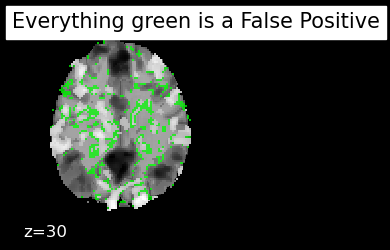

In [32]:
display = plotting.plot_stat_map(network_to_voxel_correlations_img,
                                      threshold= 0.1,
                                      cut_coords=[30],                                     
                                      display_mode='z',
                                      vmax = 1,
                                      title="Everything green is a False Positive",
                                      cmap = 'green_transparent',
                                      colorbar = False,
                                      black_bg = True)

display.add_overlay(network_to_voxel_correlations_corrected_img,
                   threshold = 0.1,
                   cmap = 'binary')

### Visualise unthresholded image

<Figure size 2000x2000 with 0 Axes>

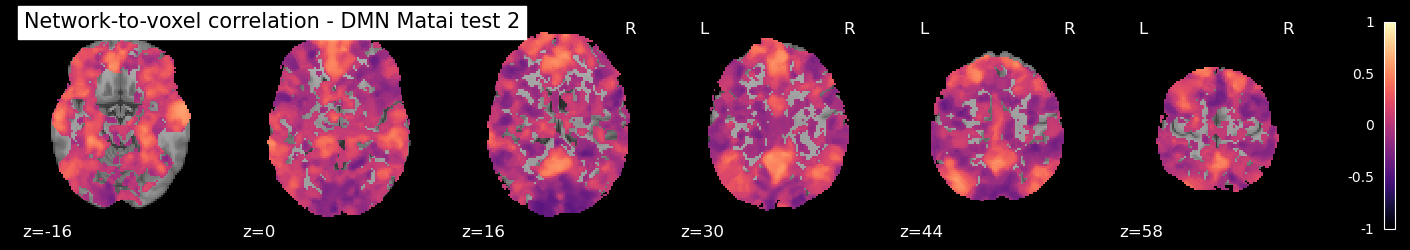

In [33]:
fig = plt.figure(figsize = (20,20))

display = plotting.plot_stat_map(network_to_voxel_correlations_corrected_img,
                                      threshold= 0,
                                      cut_coords=[-16,0,16,30,44,58],                                     
                                      display_mode='z',
                                      vmax = 1,
                                      title="Network-to-voxel correlation - {ntwk} Matai test {subject}".format(subject=subject, ntwk=ntwk),
                                      cmap = 'magma',
                                      black_bg = True)

## Visualise thresholded image against DMN nodes from MSDL atlas

C:\Users\jpmcg\anaconda3\lib\site-packages\numpy\ma\core.py:2829: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


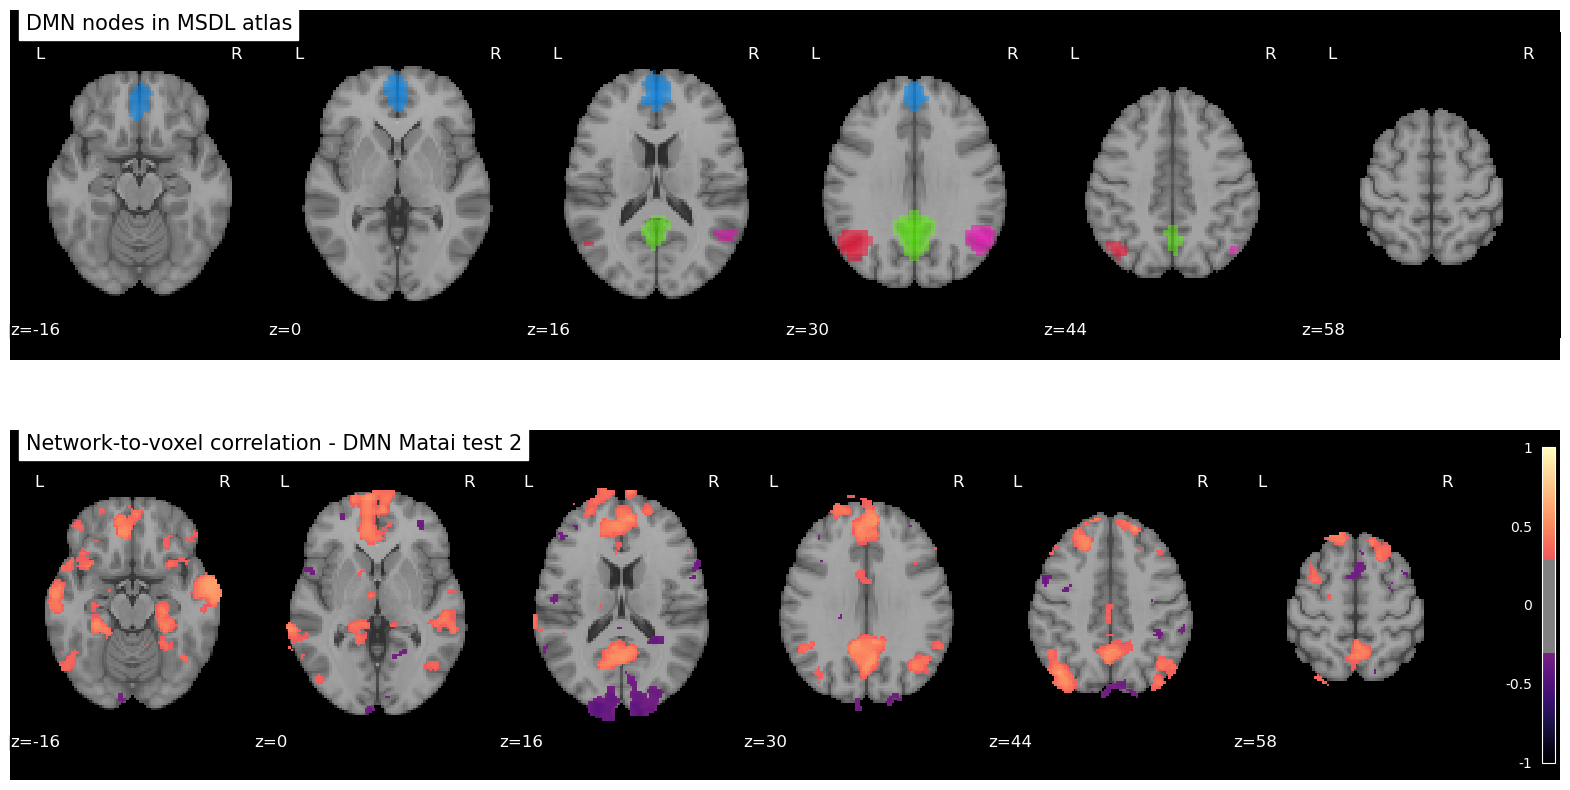

In [34]:
thresh = 0.3

fig, ax = plt.subplots(nrows=2, figsize = (20,10))

atlas_plot = plotting.plot_prob_atlas(network_nodes, cut_coords = 6,
                                      display_mode='z', title='{ntwk} nodes in MSDL atlas'.format(ntwk=ntwk),
                                      axes = ax[0], 
                                      black_bg = True)

display = plotting.plot_stat_map(network_to_voxel_correlations_corrected_img,
                                      threshold = thresh,
                                      cut_coords=[-16,0,16,30,44,58],                                     
                                      display_mode='z',
                                      vmax = 1,
                                      title="Network-to-voxel correlation - {ntwk} Matai test {subject}".format(subject=subject, ntwk=ntwk),
                                      cmap = 'magma',
                                      axes = ax[1],
                                      black_bg = True)

## Other options:

### Plotting on a surface

<img src="./supp/fmri_dmn_surf.png" 
     align="center" 
     width="500"
     height="500" />
     
### Connectomes

https://nilearn.github.io/stable/auto_examples/03_connectivity/plot_atlas_comparison.html#sphx-glr-auto-examples-03-connectivity-plot-atlas-comparison-py